# Optimizing Machine Learning Models with GridSearchCV

One of the primary challenges when developing a machine learning model is selecting the optimal model hyperparameters. Hyperparameters are the settings which define the specifics of how the model algorithm will learn. Depending on the model, they may control learning features such as how an algorithm iterates through solutions, computes internal features, or weights a prediction.

While most ML models are well documented, hyperparameter selection can still be quite obtuse. Selecting the optimal settings generally requires iterating through different options to see how they affect the model accuracy, a process call *Grid Searching*. Luckily, Scikit-learn has developed the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=grids#sklearn.model_selection.GridSearchCV">`GridSearchCV` tool</a> to automate this process. `GridSearchCV` also stores the accuracy scores of hyperparameter combinations as it iterates through options, allowing for convienent exploration of the affect of those options on the model. Let's see how it works.

In [35]:
#for when you re-load the notebook, but don't want to re-train all of the models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

lr = LogisticRegression(C=0.37926901907322497, multi_class='multinomial', penalty='l1', solver='saga')
knn = KNeighborsClassifier(algorithm='auto', n_neighbors=12, p=2, weights='distance')
tree = DecisionTreeClassifier(criterion='entropy', max_depth=18, max_features='auto', min_samples_leaf=1,
                              min_samples_split=2, splitter='best')
forest = RandomForestClassifier(criterion='gini', max_depth=14, max_features='log2', min_samples_leaf=1,
                                min_samples_split=2)
svm = SVC(C=0.001, degree=3, gamma=10.0, kernel='poly')
ann = MLPClassifier(activation='tanh', alpha=0.2782559402207126, learning_rate='adaptive', max_iter=1000,
                    solver='lbfgs')

logreg_cv = lr.fit(X_train, Y_train)
knn_cv = knn.fit(X_train, Y_train)
tree_cv = tree.fit(X_train, Y_train)
forest_cv = forest.fit(X_train, Y_train)
svm_cv = svm.fit(X_train, Y_train)
ann_cv = ann.fit(X_train, Y_train)

### 1. Import and Process Data
This project uses the "Student Adaptability Level in Online Education" public dataset on <a href="https://www.kaggle.com/datasets/mdmahmudulhasansuzan/students-adaptability-level-in-online-education">kaggle</a>, and published as <a href="https://ieeexplore.ieee.org/document/9579741">Students' Adaptability Level Prediction in Online Education using Machine Learning Approaches</a> in the *2021 12th International Conference on Computing Communication and Networking Technologies (ICCCNT)* conference procedings (DOI: 10.1109/ICCCNT51525.2021.9579741). Here, the authors collected an array of demographic, economic, and other background data for online learning students, as well as individual scores for their adaptability to online learning. The authors then used this data to predict the adaptability level of new students by building a machine learning classifier model. They compared the accuracy of a range of models, including `K-Nearest Neighbors`, `Decision Tree`, `Random Forest`, `Support Vector Machine`, `Artificial Neural Network`, and `Naive Bayes`, giving us good reference points as we develop and compare our own range of classifier models.

Let's start by downloading and importing the data as a `pandas` dataframe.

In [2]:
#download and import data
import wget
import os.path
import pandas as pd

file_path = 'data/students_adaptability_level_online_education.csv'
if not os.path.isfile(file_path):
    url = 'https://www.kaggle.com/datasets/mdmahmudulhasansuzan/students-adaptability-level-in-online-education?select=students_adaptability_level_online_education.csv'
    wget.download(url, out = file_path)
    
df = pd.read_csv(file_path)
df.head()

,Gender,Age,Education Level,Institution Type,IT Student,Location,Load-shedding,Financial Condition,Internet Type,Network Type,Class Duration,Self Lms,Device,Adaptivity Level
0,Boy,21-25,University,Non Government,No,Yes,Low,Mid,Wifi,4G,3-6,No,Tab,Moderate
1,Girl,21-25,University,Non Government,No,Yes,High,Mid,Mobile Data,4G,1-3,Yes,Mobile,Moderate
2,Girl,16-20,College,Government,No,Yes,Low,Mid,Wifi,4G,1-3,No,Mobile,Moderate
3,Girl,11-15,School,Non Government,No,Yes,Low,Mid,Mobile Data,4G,1-3,No,Mobile,Moderate
4,Girl,16-20,School,Non Government,No,Yes,Low,Poor,Mobile Data,3G,0,No,Mobile,Low


It looks like all of our variables are objects. Let's confirm before processing the data.

In [3]:
#check data structure
df.dtypes

Gender                 object
Age                    object
Education Level        object
Institution Type       object
IT Student             object
Location               object
Load-shedding          object
Financial Condition    object
Internet Type          object
Network Type           object
Class Duration         object
Self Lms               object
Device                 object
Adaptivity Level       object
dtype: object

In order to build and explore a range of classifier models, we'll need to convert the data to coded integers. To begin, let's alphabetically sort the `value_counts` of each variable and save these to a  dictionary of variable lists. We'll then use the list index of each  value as the integer in a new coded dataframe.

In [4]:
#check distribution of all data values and list values in dict
values_dict = {}
for column in df:
    print(column)
    print(df[column].value_counts().sort_index(), '\n')
    values_dict[column] = df[column].value_counts().sort_index().index.to_list()

Gender
Boy     663
Girl    542
Name: Gender, dtype: int64 

Age
1-5       81
11-15    353
16-20    278
21-25    374
26-30     68
6-10      51
Name: Age, dtype: int64 

Education Level
College       219
School        530
University    456
Name: Education Level, dtype: int64 

Institution Type
Government        382
Non Government    823
Name: Institution Type, dtype: int64 

IT Student
No     901
Yes    304
Name: IT Student, dtype: int64 

Location
No     270
Yes    935
Name: Location, dtype: int64 

Load-shedding
High     201
Low     1004
Name: Load-shedding, dtype: int64 

Financial Condition
Mid     878
Poor    242
Rich     85
Name: Financial Condition, dtype: int64 

Internet Type
Mobile Data    695
Wifi           510
Name: Internet Type, dtype: int64 

Network Type
2G     19
3G    411
4G    775
Name: Network Type, dtype: int64 

Class Duration
0      154
1-3    840
3-6    211
Name: Class Duration, dtype: int64 

Self Lms
No     995
Yes    210
Name: Self Lms, dtype: int64 

Device
Co

In [5]:
#inspect values
values_dict

{'Gender': ['Boy', 'Girl'],
 'Age': ['1-5', '11-15', '16-20', '21-25', '26-30', '6-10'],
 'Education Level': ['College', 'School', 'University'],
 'Institution Type': ['Government', 'Non Government'],
 'IT Student': ['No', 'Yes'],
 'Location': ['No', 'Yes'],
 'Load-shedding': ['High', 'Low'],
 'Financial Condition': ['Mid', 'Poor', 'Rich'],
 'Internet Type': ['Mobile Data', 'Wifi'],
 'Network Type': ['2G', '3G', '4G'],
 'Class Duration': ['0', '1-3', '3-6'],
 'Self Lms': ['No', 'Yes'],
 'Device': ['Computer', 'Mobile', 'Tab'],
 'Adaptivity Level': ['High', 'Low', 'Moderate']}

The **Age**, **Education Level**, and **Financial Condition** are ordinal. That is they have a natural rank order. Since these values are currently ordered alphabetically, the current listed order doesn't match their natural ordination. While this won't affect the accuracy of our classifier models, it does complicate data exploration and model interpretation. To make things easier down the road, let's manually re-order these values now before processing to the final coded dataframe. Just remember that when building live models, all new data will need to be pre-processed the same way.

In [6]:
#reorder lists
order = [0,5,1,2,3,4]
values_dict['Age'] = [values_dict['Age'][i] for i in order]

order = [1,0,2]
values_dict['Education Level'] = [values_dict['Education Level'][i] for i in order]
values_dict['Financial Condition'] = [values_dict['Financial Condition'][i] for i in order]

order = [1,0]
values_dict['Institution Type'] = [values_dict['Institution Type'][i] for i in order]
values_dict['Load-shedding'] = [values_dict['Load-shedding'][i] for i in order]

order = [1,2,0]
values_dict['Adaptivity Level'] = [values_dict['Adaptivity Level'][i] for i in order]

values_dict

{'Gender': ['Boy', 'Girl'],
 'Age': ['1-5', '6-10', '11-15', '16-20', '21-25', '26-30'],
 'Education Level': ['School', 'College', 'University'],
 'Institution Type': ['Non Government', 'Government'],
 'IT Student': ['No', 'Yes'],
 'Location': ['No', 'Yes'],
 'Load-shedding': ['Low', 'High'],
 'Financial Condition': ['Poor', 'Mid', 'Rich'],
 'Internet Type': ['Mobile Data', 'Wifi'],
 'Network Type': ['2G', '3G', '4G'],
 'Class Duration': ['0', '1-3', '3-6'],
 'Self Lms': ['No', 'Yes'],
 'Device': ['Computer', 'Mobile', 'Tab'],
 'Adaptivity Level': ['Low', 'Moderate', 'High']}

In [7]:
#build integer-coded dataframe
coded_dict = {}
for column in df:
    coded_dict[column] = []
    for i in range(0,df.shape[0]):
        coded_dict[column].append(values_dict[column].index(df[column][i]))

coded_df = pd.DataFrame(coded_dict)
coded_df.head()

,Gender,Age,Education Level,Institution Type,IT Student,Location,Load-shedding,Financial Condition,Internet Type,Network Type,Class Duration,Self Lms,Device,Adaptivity Level
0,0,4,2,0,0,1,0,1,1,2,2,0,2,1
1,1,4,2,0,0,1,1,1,0,2,1,1,1,1
2,1,3,1,1,0,1,0,1,1,2,1,0,1,1
3,1,2,0,0,0,1,0,1,0,2,1,0,1,1
4,1,3,0,0,0,1,0,0,0,1,0,0,1,0


### 2. Data Exploration
Now that the data is integer-coded, we can look for any obvious trends in dataset. I always like to start with a correlation matrix, which quickly visualizes correlated variables. Here, we'll use *Spearmans' rank correlation* to account for the fact that these are ranked integers, and we'll plot the resulting matrix as a heatmap. 

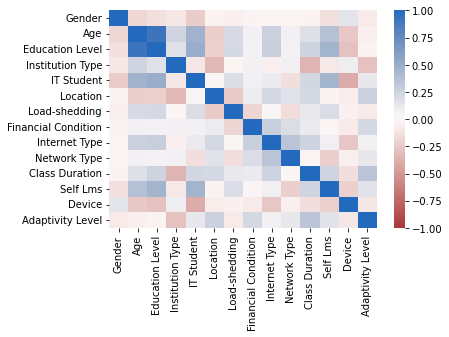

In [8]:
#plot correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

cmap = sns.color_palette("vlag", as_cmap=True).reversed()
sns.heatmap(coded_df.corr(method='spearman'), cmap=cmap, vmin=-1, vmax=1)
plt.show()

Given that it takes time to obtain an education (and most of us progress at a similar rate), it's no surprise that **Age** and **Education Level** correlate quite strongly with each other. There are no strong individual correlations to **Adaptivity Level** however, indicating the need for a multivariate exploration. Noteably, there are weak positive correlations between the response variable and **Class Duration**, **Financial Condition**, and **Location**, which seems to indicate that well-resourced students who live in a town and recieve more teacher interaction adapt the best. There is also a weak negative correlation with **Institution Type**, suggesting that non-government schools enable higher adaptability than government schools.

Since none of the variable strongly correlate the **Adaptivity Level**, let's ordinate (dimentially reduce) the data and see if there are any clusters in overall data structure. First, we'll standardize the data. Then we'll ordinate with `Principal Component Analysis`, which projects the full data along dimensions of the greatest variability (read more about ordination <a href="https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c">here</a>).

In [9]:
#split X and Y, and standardize X
import numpy as np
import sklearn
from sklearn import preprocessing

Y = coded_df['Adaptivity Level'].to_numpy()
X = coded_df.loc[:, coded_df.columns != 'Adaptivity Level'].to_numpy()
xform = preprocessing.StandardScaler()
X_z = xform.fit(X).transform(X)

In [10]:
#define pca plot fuction
def plot_pca(ordi,lab,y):
    '''
    Generates biplot of 1st and 2nd axes from an ordination model
    '''
    plt.figure()
    plt.scatter(ordi[y==0, 0], ordi[y==0, 1], color='red', label='Low')
    plt.scatter(ordi[y==1, 0], ordi[y==1, 1], color='blue', label='Moderate')
    plt.scatter(ordi[y==2, 0], ordi[y==2, 1], color='green', label='High')
    plt.xlabel(lab[0])
    plt.ylabel(lab[1])
    plt.legend()
    plt.show()

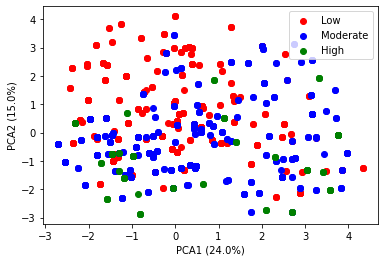

In [11]:
#train and plot PCA
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(X_z)
labels = [f"PCA1 ({pca.explained_variance_ratio_[0]*100:.1f}%)",
          f"PCA2 ({pca.explained_variance_ratio_[1]*100:.1f}%)"]
plot_pca(X_pca,labels,Y)

While there is a slight visible trend of *Low* adaptability toward the upper left and *High* adaptability toward the lower right, this trend is weak and highly blended. The first and second *principal components* only account for 39.0% of the total data variability, so we can't acheive meaningful separations in the data from just 2 dimensions of a simple ordination. There are additional ordination methods which apply more structured data projection in an attempt to maximize the inherent data structures. `t-Distributed Stochastic Neighbor Embedding` is one such method which attempts to maximize natural data clusters.

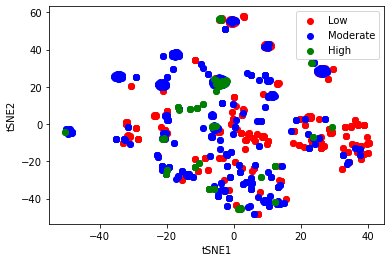

In [12]:
#train and plot tSNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, learning_rate=300, perplexity=30, early_exaggeration=12, init='random', random_state=2019)
X_tsne = tsne.fit_transform(X_z)
labels = ["tSNE1","tSNE2"]
plot_pca(X_tsne,labels,Y)

There are clearly a number of similar student clusters, but they do not separate by adaptivity level. Let's see what we can do with some common ML classifier algoriths. Here, we'll use `Logistic Regression`, `K-Nearest Neighbors`, `Decision Tree`, `Random Forest`, `Support Vector Machine`, and `Artificial Neural Network`. In the original publication, the authors did not use `Logistic Regression`, which often doesn't perform as well for n>2 classes even though it does allow multi-classing. They did, however, build a `Naive Bayes` model, which assumes that none of the independent variables influence each other. However, we can reasonably assume interactions between certain variables, such as how more highly educated students are likely to be older, and how financially well-off students are more likely to be able to afford higher internet speeds and more expensive devices. This is therefore not a valid assumption for this dataset, and so we will not include a `Naive Bayes` model.

### 3. Model Optimization with GridSearchCV
All machine learning algorithms have a range of hyperparameters which effect how they build the model. These include `regularization parameters`, `scaling values`, `solver algorithms`, `tree depth`, and `number of neighbors`, among many others. The optimal setting for any of these hyperparameters is rarely obvious, and so it's necessary to iterate and measure model accuracy over a range of these settings. `GridSearchCV` automates this process by running replicate `cross-validations` of all combinations of these hyperparameters, and then selecting the hyperparameter set with the highest model accuracy.

We'll start by randomly splitting the data into training (80%) and testing (20%) sets. `GridSearchCV` will also test-train split the input training data, and so the reported accuracy in-sample training accuracy. To compare and select the best overall model, we'll also need to measure out-of-sample accuracy with the test set. We'll also filter out warning messages to limit the printouts to progress messages only. 

In [13]:
#split train and test datasets
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_z, Y, test_size=0.2, random_state=2)

In [14]:
#ignore all warnings
from warnings import simplefilter

simplefilter(action='ignore')

Now we can begin optimizing our first model. Let's begin with `Logistic Regression`. It's always a good idea to look over the hyperparameter descriptions in the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html">user guide</a> before building a new model. For our dataset, we'll optimize the `C`, `penalty`, and `solver` hyperparameters, while setting `multi_class` to `multinomial`. This is done using a `parameters` dictionary. We then make a `GridSearchCV` object using `parameters` a `Logisitic Regression` model object, and a defined number of `cross-validations` (here we're using 10). Finally, we optimize our model by fitting our training data.

In [195]:
#train logistic regression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

parameters = {'C': np.logspace(-2, 0, 20),
              'penalty': ['none', 'l2', 'l1', 'elasticnet'],
              'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
              'multi_class': ['multinomial']}
lr = LogisticRegression()
grid_search = GridSearchCV(lr, parameters, cv=10, verbose=0)
logreg_cv = grid_search.fit(X_train, Y_train)

Once `GridSearchCV` has finished optimizing our model, we can check our final hyperparameter values, in-sample accuracy, and out-of-sample accuracy.

In [196]:
#test logistic regression
print("Tuned hpyerparameters (best parameters):", logreg_cv.best_params_)
print("Train accuracy:", logreg_cv.best_score_)
print("Test accuracy:", logreg_cv.best_estimator_.score(X_test, Y_test))

Tuned hpyerparameters (best parameters): {'C': 0.37926901907322497, 'multi_class': 'multinomial', 'penalty': 'l1', 'solver': 'saga'}
Train accuracy: 0.6981099656357388
Test accuracy: 0.6929460580912863


We can also extract the in-sample scores for each combination of tested hyperparameters to explore how each parameter affects the model accuracy.

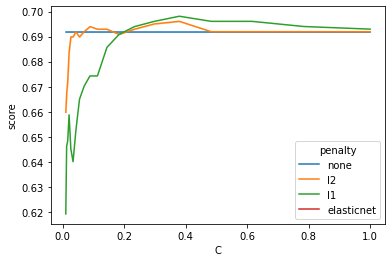

In [197]:
#plot logreg scores
logreg_cv_df = pd.DataFrame(logreg_cv.cv_results_['params'])
logreg_cv_df['score'] = logreg_cv.cv_results_['mean_test_score']

sns.lineplot(data=logreg_cv_df, x='C', y='score', hue='penalty')
plt.show()

The most accurate `Logistic Regression` model was achieved with l1 and l2 `pentalty` terms, and a `regularization` of about 0.4. Still, at a maximum accuracty 70%, this vastly underperforms the best model from the original publication (89.63% accuracy achieved with a `Random Forest` model).

Let's see if we can get a better result using `K-Nearest Neighbors`.

In [16]:
#train k-nearest neighbors
from sklearn.neighbors import KNeighborsClassifier

parameters = {'n_neighbors': list(range(1, 20)),
              'weights': ['uniform', 'distance'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, parameters, cv=10, verbose=0)
knn_cv = grid_search.fit(X_train, Y_train)

In [17]:
#test k-nearest neighbors
print("Tuned hpyerparameters (best parameters):", knn_cv.best_params_)
print("Train accuracy:", knn_cv.best_score_)
print("Test accuracy:", knn_cv.best_estimator_.score(X_test, Y_test))

Tuned hpyerparameters (best parameters): {'algorithm': 'auto', 'n_neighbors': 12, 'p': 2, 'weights': 'distance'}
Train accuracy: 0.9148518041237113
Test accuracy: 0.8879668049792531


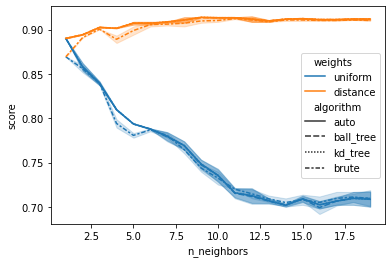

In [160]:
#plot knn scores
knn_cv_df = pd.DataFrame(knn_cv.cv_results_['params'])
knn_cv_df['score'] = knn_cv.cv_results_['mean_test_score']

sns.lineplot(data=knn_cv_df, x='n_neighbors', y='score', hue='weights', style='algorithm')
plt.show()

The neighborhood `weighting` method was the most influential hyperparamter on the accuracy of the `K-Nearest Neighbors` model. Type of computational `algorithm` also played a strong role at lower `n_neighbor` values, but its influence diminished above about 10 neighbors. This model acheived an out-of-sample accuracy of 88.80%, which approaches the 89.63% accuracy that the original authors achieved with a `Random Forest` model.

Next, let's build a `Decision Tree`.

In [212]:
#train decision tree
from sklearn.tree import DecisionTreeClassifier

parameters = {'criterion': ['gini', 'entropy', 'log_loss'],
              'splitter': ['best', 'random'],
              'max_depth': [2*n for n in range(1,10)],
              'max_features': ['auto', 'sqrt', 'log2'],
              'min_samples_leaf': [1, 2, 4],
              'min_samples_split': [2, 5, 10]}
tree = DecisionTreeClassifier()
grid_search = GridSearchCV(tree, parameters, cv=10, verbose=0)
tree_cv = grid_search.fit(X_train, Y_train)

In [213]:
#test decision tree
print("Tuned hpyerparameters (best parameters):", tree_cv.best_params_)
print("Train accuracy:", tree_cv.best_score_)
print("Test accuracy:", tree_cv.best_estimator_.score(X_test, Y_test))

Tuned hpyerparameters (best parameters): {'criterion': 'entropy', 'max_depth': 18, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Train accuracy: 0.9148625429553265
Test accuracy: 0.8838174273858921


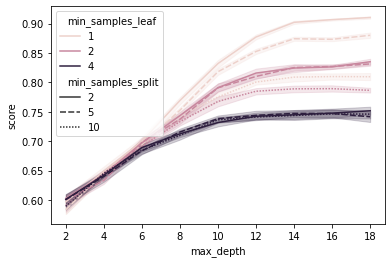

In [214]:
#plot decision tree scores
tree_cv_df = pd.DataFrame(tree_cv.cv_results_['params'])
tree_cv_df['score'] = tree_cv.cv_results_['mean_test_score']

sns.lineplot(data=tree_cv_df, x='max_depth', y='score', hue='min_samples_leaf', style='min_samples_split')
plt.show()

The `Decision Tree` model perfomed best with minimal `min_samples_leaf` and `min_samples_split` values and a high tree `max_depth`. This indicates that the model needs to make many small divisions in order to class the samples, which is consistent with the difficulty generating clusters by ordination. The model still achieved a high 88.38% accuracy, though this high-depth, fine-grain variable splitting is not terribly efficient.

Now on to `Random Forest`, which is a `Decision Tree` "meta estimator". It also gave the original authors their best result.

In [41]:
#train random forest
from sklearn.ensemble import RandomForestClassifier

parameters = {'criterion': ['gini', 'entropy', 'log_loss'],
              'max_depth': [2*n for n in range(1,10)],
              'max_features': ['auto', 'sqrt', 'log2'],
              'min_samples_leaf': [1, 2, 4],
              'min_samples_split': [2, 5, 10]}
forest = RandomForestClassifier()
grid_search = GridSearchCV(forest, parameters, cv=10, verbose=0)
forest_cv = grid_search.fit(X_train, Y_train)

In [42]:
#test random forest
print("Tuned hpyerparameters (best parameters):", forest_cv.best_params_)
print("Train accuracy:", forest_cv.best_score_)
print("Test accuracy:", forest_cv.best_estimator_.score(X_test, Y_test))

Tuned hpyerparameters (best parameters): {'criterion': 'entropy', 'max_depth': 14, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2}
Train accuracy: 0.9117160652920961
Test accuracy: 0.8879668049792531


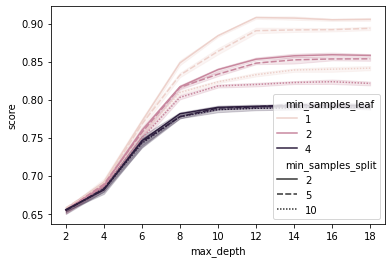

In [43]:
#plot random forest scores
forest_cv_df = pd.DataFrame(forest_cv.cv_results_['params'])
forest_cv_df['score'] = forest_cv.cv_results_['mean_test_score']

sns.lineplot(data=forest_cv_df, x='max_depth', y='score', hue='min_samples_leaf', style='min_samples_split')
plt.show()

Our `Random Forest` model, which takes a consensus *vote* from 100 independent decision trees, only marginally improved upon the accuracy of the original `Decision Tree`. It still relied on minimal `min_samples_leaf` and `min_samples_split` values, though did reduce the `max_depth` to 14. It is surprising that our `Random Forest` underperformed compared to the original publication, though the authors didn't describe which hyperparameters they chose, and we didn't tune all of the posible parameters here.

We'll optimize our `Support Vector Machine` model slightly differently. `SVM`s find a hyperplane function to maximise separation between classes, adding a higher dimentionality to the data in sort of an inverse ordination. This is a computationally expensive model to build compared to the others, and my machine (32GB RAM, 3600Mhz/8CPU) stalled when trying to run it through `GridSearchCV` all at once. The nested for-loop approach used here is a manual iteration of `GridSearchCV`, which performs only a fraction of the total Grid Search at a time. This still took my machine 4 days to complete, so I recommend enabling some amount of progress messaging with the `verbose` setting to maintain your sanity.

In [20]:
#train support vector machine
from sklearn.svm import SVC

svm_params = []
svm_scores = np.empty(0)
for i in np.logspace(-3, 3, 10):
    for j in range(2,5):
        for k in np.logspace(-3, 1, 10):
            parameters = {'C': [i],
                          'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                          'degree': [j],
                          'gamma': [k]}
            svm = SVC()
            grid_search = GridSearchCV(svm, parameters, cv=10, verbose=1)
            svm_cv = grid_search.fit(X_train, Y_train)
            
            svm_params = svm_params + svm_cv.cv_results_['params']
            svm_scores = np.append(svm_scores, svm_cv.cv_results_['mean_test_score'])

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for eac

In [21]:
#test support vector machine
print("Tuned hpyerparameters (best parameters):", svm_params[np.argmax(svm_scores)])
print("Train accuracy:", np.max(svm_scores))
svm_cv = SVC(C=svm_params[np.argmax(svm_scores)]['C'],
             degree=svm_params[np.argmax(svm_scores)]['degree'],
             gamma=svm_params[np.argmax(svm_scores)]['gamma'],
             kernel=svm_params[np.argmax(svm_scores)]['kernel'])
svm_cv.fit(X_train, Y_train)
print("Test accuracy:", svm_cv.score(X_test, Y_test))

Tuned hpyerparameters (best parameters): {'C': 0.001, 'degree': 3, 'gamma': 10.0, 'kernel': 'poly'}
Train accuracy: 0.9096649484536083
Test accuracy: 0.8921161825726142


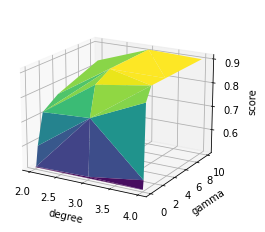

In [211]:
#plot svm scores
svm_cv_df = pd.DataFrame(svm_params)
svm_cv_df['score'] = svm_scores

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_trisurf(svm_cv_df[(svm_cv_df['C']==0.001) & (svm_cv_df['kernel']=='poly')]['degree'],
                       svm_cv_df[(svm_cv_df['C']==0.001) & (svm_cv_df['kernel']=='poly')]['gamma'],
                       svm_cv_df[(svm_cv_df['C']==0.001) & (svm_cv_df['kernel']=='poly')]['score'],
                       cmap=plt.cm.viridis, linewidth=0.2)
ax.view_init(18,300)
ax.set_xlabel('degree')
ax.set_ylabel('gamma')
ax.set_zlabel('score')
plt.show()

The `Support Vector Machine` provided the best classification with 89.21% accuracy. Though this still slightly under performs the model in the original publication. Polynomial `degree` and `gamma` scaling were the most important hyperparameters.

Finally, let's look at an `Artificial Neural Net` model.

In [38]:
#train artificial neural network
from sklearn.neural_network import MLPClassifier

parameters = {'activation': ['identity', 'logistic', 'tanh', 'relu'],
              'solver': ['lbfgs', 'sgd', 'adam'],
              'alpha': np.logspace(-5, 0, 10),
              'learning_rate': ['adaptive'],
              'max_iter': [1000]}
ann = MLPClassifier()
grid_search = GridSearchCV(ann, parameters, cv=10, verbose=0)
ann_cv = grid_search.fit(X_train, Y_train)

In [39]:
#test artificial neural network
print("Tuned hpyerparameters (best parameters):", ann_cv.best_params_)
print("Train accuracy:", ann_cv.best_score_)
print("Test accuracy:", ann_cv.best_estimator_.score(X_test, Y_test))

Tuned hpyerparameters (best parameters): {'activation': 'relu', 'alpha': 1e-05, 'learning_rate': 'adaptive', 'max_iter': 1000, 'solver': 'adam'}
Train accuracy: 0.9148410652920962
Test accuracy: 0.8921161825726142


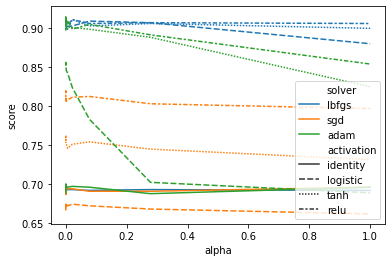

In [40]:
#plot ann scores
ann_cv_df = pd.DataFrame(ann_cv.cv_results_['params'])
ann_cv_df['score'] = ann_cv.cv_results_['mean_test_score']

sns.lineplot(data=ann_cv_df, x='alpha', y='score', hue='solver', style='activation')
plt.legend(loc='lower right')
plt.show()

The `Artificial Neural Network` had higher in-sample accuracy than the `Support Vector Machine`, but equal out-of-sample accuracy at 89.21%. The `solver` hyperparameter had the largest impact on model accuracy, with lbfgs performing the best, especially with the tanh and relu `activation` functions. This is in line with the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html?highlight=mlpclassifier#sklearn.neural_network.MLPClassifier">ANN documentation</a>, which recommends lbfgs for faster convergence on small datasets.

`GridSearchCV` was also able to optimize the ANN much faster than the SVM at 1 hour versus 4 days, making ANN the more efficient implementation option for this dataset.

### 4. Final Model Comparisons
Finally, we'll directly compare the model accuracies and build confusion matrices to see where each model excels and struggles.

In [44]:
#compare models
print("Logistic Regression: {}\nKNN: {}\nDecision Tree: {}\nRandom Forest: {}\nSVM: {}\nANN: {}".format(
    logreg_cv.best_estimator_.score(X_test, Y_test),
    knn_cv.best_estimator_.score(X_test, Y_test),
    tree_cv.best_estimator_.score(X_test, Y_test),
    forest_cv.best_estimator_.score(X_test, Y_test),
    svm_cv.score(X_test, Y_test),
    ann_cv.best_estimator_.score(X_test, Y_test)))
# for when you've rerun the models in the first block instead of running GridSearchCV
#    logreg_cv.score(X_test, Y_test),
#    knn_cv.score(X_test, Y_test),
#    tree_cv.score(X_test, Y_test),
#    forest_cv.score(X_test, Y_test),
#    svm_cv.score(X_test, Y_test),
#    ann_cv.score(X_test, Y_test)))

Logistic Regression: 0.6929460580912863
KNN: 0.8879668049792531
Decision Tree: 0.8838174273858921
Random Forest: 0.8879668049792531
SVM: 0.8921161825726142
ANN: 0.8921161825726142


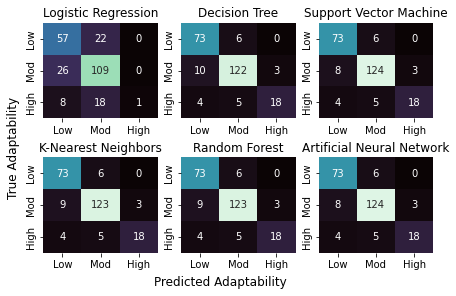

In [45]:
#plot confusion matrices using model predictions
from sklearn.metrics import confusion_matrix

logreg_cm = confusion_matrix(Y_test, logreg_cv.predict(X_test))
knn_cm = confusion_matrix(Y_test, knn_cv.predict(X_test))
tree_cm = confusion_matrix(Y_test, tree_cv.predict(X_test))
forest_cm = confusion_matrix(Y_test, forest_cv.predict(X_test))
svm_cm = confusion_matrix(Y_test, svm_cv.predict(X_test))
ann_cm = confusion_matrix(Y_test, ann_cv.predict(X_test))

vmax = max(np.amax(logreg_cm), np.amax(knn_cm), np.amax(tree_cm), np.amax(forest_cm), np.amax(svm_cm), np.amax(ann_cm))

fig, axs = plt.subplots(2, 3, constrained_layout=True)

sns.heatmap(logreg_cm, annot=True, cbar=False, ax=axs[0,0], cmap='mako', fmt='g', vmin=0, vmax=vmax)
sns.heatmap(knn_cm, annot=True, cbar=False, ax=axs[1,0], cmap='mako', fmt='g', vmin=0, vmax=vmax)
sns.heatmap(tree_cm, annot=True, cbar=False, ax=axs[0,1], cmap='mako', fmt='g', vmin=0, vmax=vmax)
sns.heatmap(forest_cm, annot=True, cbar=False, ax=axs[1,1], cmap='mako', fmt='g', vmin=0, vmax=vmax)
sns.heatmap(svm_cm, annot=True, cbar=False, ax=axs[0,2], cmap='mako', fmt='g', vmin=0, vmax=vmax)
sns.heatmap(ann_cm, annot=True, cbar=False, ax=axs[1,2], cmap='mako', fmt='g', vmin=0, vmax=vmax)

axs[0,0].set_title('Logistic Regression')
axs[1,0].set_title('K-Nearest Neighbors')
axs[0,1].set_title('Decision Tree')
axs[1,1].set_title('Random Forest')
axs[0,2].set_title('Support Vector Machine')
axs[1,2].set_title('Artificial Neural Network')

axs[0,0].xaxis.set_ticklabels(['Low', 'Mod', 'High'])
axs[1,0].xaxis.set_ticklabels(['Low', 'Mod', 'High'])
axs[0,1].xaxis.set_ticklabels(['Low', 'Mod', 'High'])
axs[1,1].xaxis.set_ticklabels(['Low', 'Mod', 'High'])
axs[0,2].xaxis.set_ticklabels(['Low', 'Mod', 'High'])
axs[1,2].xaxis.set_ticklabels(['Low', 'Mod', 'High'])

axs[0,0].yaxis.set_ticklabels(['Low', 'Mod', 'High'])
axs[1,0].yaxis.set_ticklabels(['Low', 'Mod', 'High'])
axs[0,1].yaxis.set_ticklabels(['Low', 'Mod', 'High'])
axs[1,1].yaxis.set_ticklabels(['Low', 'Mod', 'High'])
axs[0,2].yaxis.set_ticklabels(['Low', 'Mod', 'High'])
axs[1,2].yaxis.set_ticklabels(['Low', 'Mod', 'High'])

fig.supxlabel('Predicted Adaptability')
fig.supylabel('True Adaptability')

plt.show()

Here, we can see that the poor result from `Logistic Regression` resulted from a tendency toward binary predictions, classifying the **Adaptability** of all but one student as either *Low* or *Moderate* despite the `mutli_class` parameter being optimized to `multinomial`. Each of the other models were nearly identical, only differing in the number of underclassified *Moderately Adaptable* students.

Finally, let's compare how the the in- and out-of-sample accuracies change for each model.

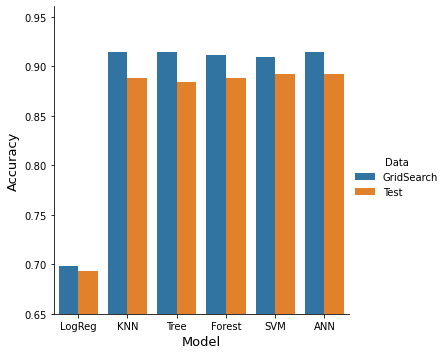

In [49]:
#compare model accuracies
model_acc = {'Model': ['LogReg', 'KNN', 'Tree', 'Forest', 'SVM', 'ANN',
                       'LogReg', 'KNN', 'Tree', 'Forest', 'SVM', 'ANN'],
             'Accuracy': [logreg_cv.best_score_,
                          knn_cv.best_score_,
                          tree_cv.best_score_,
                          forest_cv.best_score_,
                          np.max(svm_scores),
                          ann_cv.best_score_,
                          logreg_cv.best_estimator_.score(X_test, Y_test),
                          knn_cv.best_estimator_.score(X_test, Y_test),
                          tree_cv.best_estimator_.score(X_test, Y_test),
                          forest_cv.best_estimator_.score(X_test, Y_test),
                          svm_cv.score(X_test, Y_test),
                          ann_cv.best_estimator_.score(X_test, Y_test)],
             'Data': ['GridSearch', 'GridSearch', 'GridSearch', 'GridSearch', 'GridSearch', 'GridSearch',
                      'Test', 'Test', 'Test', 'Test', 'Test', 'Test']}

model_df = pd.DataFrame(model_acc)

sns.catplot(kind='bar', y='Accuracy', x='Model', hue='Data', data=model_df)
plt.ylim(0.65, None)
plt.xlabel('Model', fontsize=13)
plt.ylabel('Accuracy', fontsize=13)
plt.show()

In-sample accuracy was higher than out-of-sample accuracy for every single model, demonstrating the importance of training and verifying models using different data. Asside from `Logistic Regression`, the accuracy of the different models was very comparable. Our final model selection came down to a training efficiency choice between the `Support Vector Machine` and `Artificial Nueral Network` models, though `K-Nearest Neighbors`, `Decision Tree`, or `Random Forest` were each significantly faster than ANN, and only marginally less accurate on this dataset. Depending on your computation resources, better training efficiency could reasonably sway the final model choice to any of these other three.

### 5. Conclusions
As we can see, `GridSearchCV` is an indispensible tool for machine learning model selection, allowing quick and convenient comparisons between the hyperparameters of multiple models. For more resource-intensive models like `Support Vector Machines`, however, it is sometimes necessary to manually iterate `GridSearchCV` in order for it to complete. This is easy to do with for-loops.

Before settling on and deploying your model, it's always a good idea to cross-validate your model accruacy by re-sampling your training and testing data. This can be done with <a href="https://medium.com/r/?url=https%3A%2F%2Fscikit-learn.org%2Fstable%2Fmodules%2Fgenerated%2Fsklearn.model_selection.cross_val_score.html">Scikit-learn's `cross_val_score` tool</a>, which I may cover in a future post.